from datasets import load_dataset
files = [f"D:/tokenized/temp_chunk_{i:04d}.parquet" for i in range(77)]
dataset = load_dataset("parquet", data_files=files, streaming=True)
first_row = next(iter(dataset["train"]))
print(first_row)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, IterableDataset
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import os
import json
import numpy as np
from pathlib import Path
import argparse
from tqdm import tqdm
import wandb
from transformers import PreTrainedTokenizerFast
from datasets import load_dataset
import time
import math
from model.transformer import SpikingLLM, SpikingMoELLM, RegularLLM
import matplotlib.pyplot as plt

In [2]:
class PreTokenizedDataset(IterableDataset):
    def __init__(self, data_dir, seq_len=1024, vocab_size=65536, chunks_start=0, chunks_end=77):
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        files = [f"{data_dir}/temp_chunk_{i:04d}.parquet" for i in range(chunks_start, chunks_end)]
        self.dataset = load_dataset("parquet", data_files=files, streaming=True)["train"]
        
    def __iter__(self):
        for item in self.dataset:
            tokens = torch.tensor(item['input_ids'], dtype=torch.long)
            
            if len(tokens) < self.seq_len + 1:
                padding = torch.zeros(self.seq_len + 1 - len(tokens), dtype=torch.long)
                tokens = torch.cat([tokens, padding])
            else:
                tokens = tokens[:self.seq_len + 1]
            
            input_ids = tokens[:-1]
            labels = tokens[1:]
            
            yield {
                'input_ids': input_ids,
                'labels': labels
            }

In [3]:
def get_model_configs():
    return {
        "35m": {
            "vocab_size": 65536,
            "d_model": 256,
            "n_heads": 4,
            "n_kv_heads": 2,
            "num_layers": 2,
            "intermediate_size": 512,
            "max_seq_len": 2048,
            "rope_theta_local": 10_000,
            "rope_theta_global": 1_000_000,
            "window_size": 256,
            "dropout": 0.0,
            "beta": 0.95,"num_steps":5,
        },
        "170m": {
            "vocab_size": 65536,
            "d_model": 512,
            "n_heads": 8*4,
            "n_kv_heads": 4*4,
            "num_layers": 8*4,
            "intermediate_size": 1536,
            "max_seq_len": 4096,
            "rope_theta_local": 10_000,
            "rope_theta_global": 1_000_000,
            "window_size": 512,
            "dropout": 0.0,
            "beta": 0.95,"num_steps":5,
        },
        "350m": {
            "vocab_size": 65536,
            "d_model": 768,
            "n_heads": 32,
            "n_kv_heads": 16,
            "num_layers": 32,
            "intermediate_size": 2560,
            "max_seq_len": 8192,
            "rope_theta_local": 10_000,
            "rope_theta_global": 1_000_000,
            "window_size": 1024,
            "dropout": 0.0,
            "beta": 0.95,"num_steps":5,
        },
}

In [4]:
def get_lr_schedule(step, warmup_steps, max_steps, max_lr, min_lr):
    if max_steps is None:
        return max_lr if step >= warmup_steps else max_lr * step / warmup_steps
    if step < warmup_steps:
        return max_lr * step / warmup_steps
    if step > max_steps:
        return min_lr
    decay_ratio = (step - warmup_steps) / (max_steps - warmup_steps)
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (max_lr - min_lr)

def collect_spike_activity(model):
    spike_rates = {}
    total_spikes = 0
    total_neurons = 0
    
    for name, module in model.named_modules():
        if hasattr(module, 'spike_mem') and module.spike_mem is not None:
            if hasattr(module, 'spike'):
                spike_rate = torch.mean(module.spike_mem.float()).item()
                spike_rates[f"spike_rate/{name}"] = spike_rate
                total_spikes += torch.sum(module.spike_mem).item()
                total_neurons += module.spike_mem.numel()
    
    if total_neurons > 0:
        spike_rates["spike_rate/overall"] = total_spikes / total_neurons
    
    return spike_rates

In [5]:
def setup_plots():
    plt.ion()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    return fig, ax1, ax2

def update_plots(ax1, ax2, steps, losses, spike_rates, output_dir):
    ax1.clear()
    ax1.plot(steps, losses, 'b-', alpha=0.7)
    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.grid(True)
    
    ax2.clear()
    if spike_rates:
        ax2.plot(steps, spike_rates, 'r-', alpha=0.7)
        ax2.set_xlabel('Steps')
        ax2.set_ylabel('Spike Rate')
        ax2.set_title('Overall Spike Activity')
        ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_progress.png'), dpi=150, bbox_inches='tight')

In [6]:
def train_epoch(model, dataloader, optimizer, device, gradient_accumulation_steps, max_grad_norm):
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Training")):
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        
        with torch.cuda.amp.autocast():
            logits, _ = model(input_ids)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))
            loss = loss / gradient_accumulation_steps
        
        loss.backward()
        
        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss.item() * gradient_accumulation_steps
        num_batches += 1
    
    return total_loss / num_batches

In [7]:
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            with torch.cuda.amp.autocast():
                logits, _ = model(input_ids)
                loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))
            
            total_loss += loss.item()
            num_batches += 1
    
    return total_loss / num_batches

In [8]:
MODEL_SIZE = '170m'
USE_MOE = False
MOE_RATIO = 0.25
DATA_DIR = 'D:/tokenized'
TOKENIZER_PATH = 'D:/fineweb-chunked/clean-bpe-tokenizer'
OUTPUT_DIR = './checkpoints'
SEQ_LEN = 1024
BATCH_SIZE = 4
GRADIENT_STEPS = 2
LR = 1e-4
W_DECAY = 0.01
MAX_GRAD_NORM = 1.0
NUM_EPOCHS = 1
WARMUP_STEPS = 2_000 #8_000
MAX_STEPS = None
EVAL_INTERVAL = 1_000
SAVE_INTERVAL = 5_000
RESUME_FROM = None

In [9]:
if torch.cuda.is_available():
	device = torch.device("cuda")
	torch.backends.cudnn.benchmark = True
else:
	device = torch.device("cpu")

print(f"Running on {device}")

Running on cuda


In [10]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [11]:
config = get_model_configs()[MODEL_SIZE]
config["max_seq_len"] = max(config["max_seq_len"], SEQ_LEN)

In [12]:
if USE_MOE:
	num_moe_layers = max(1, int(config["num_layers"] * MOE_RATIO))
	step = config["num_layers"] // num_moe_layers
	moe_layers = [i * step + step - 1 for i in range(num_moe_layers)]
	config.update({
		"moe_layers": moe_layers,
		"num_experts": 8,
		"num_active": 2,
		"tie_embeddings": True,
		"embedding_dropout": 0.0,
	})
	model = SpikingMoELLM(**config).to(device)
	print("Loaded MoE model")
else:
	#model = RegularLLM(**config).to(device)
	model = SpikingLLM(**config).to(device)
	print("Loaded Dense model")

Loaded Dense model


In [13]:
print(f"Model parameters: {model.get_num_params():,}")
if USE_MOE and hasattr(model, 'count_moe_params'):
	moe_params, regular_params = model.count_moe_params()
	active_params = regular_params + moe_params * (config["num_active"] / config["num_experts"])
	print(f"Active parameters: {active_params:,}")

Model parameters: 167,920,320


In [14]:
tokenizer = PreTrainedTokenizerFast.from_pretrained(TOKENIZER_PATH)

In [15]:
dataset = PreTokenizedDataset(DATA_DIR, SEQ_LEN, config["vocab_size"], 0, 70)
eval_dataset = PreTokenizedDataset(DATA_DIR, SEQ_LEN, config["vocab_size"], 70, 77)

Resolving data files:   0%|          | 0/70 [00:00<?, ?it/s]

In [16]:
train_loader = DataLoader(
	dataset, 
	batch_size=BATCH_SIZE, 
	num_workers=0,
	pin_memory=True
)
eval_loader = DataLoader(
	eval_dataset, 
	batch_size=BATCH_SIZE, 
	num_workers=0,
	pin_memory=True
)

In [17]:
optimizer = torch.optim.AdamW(
	model.parameters(),
	lr=LR,
	weight_decay=W_DECAY,
	betas=(0.9, 0.95)
)

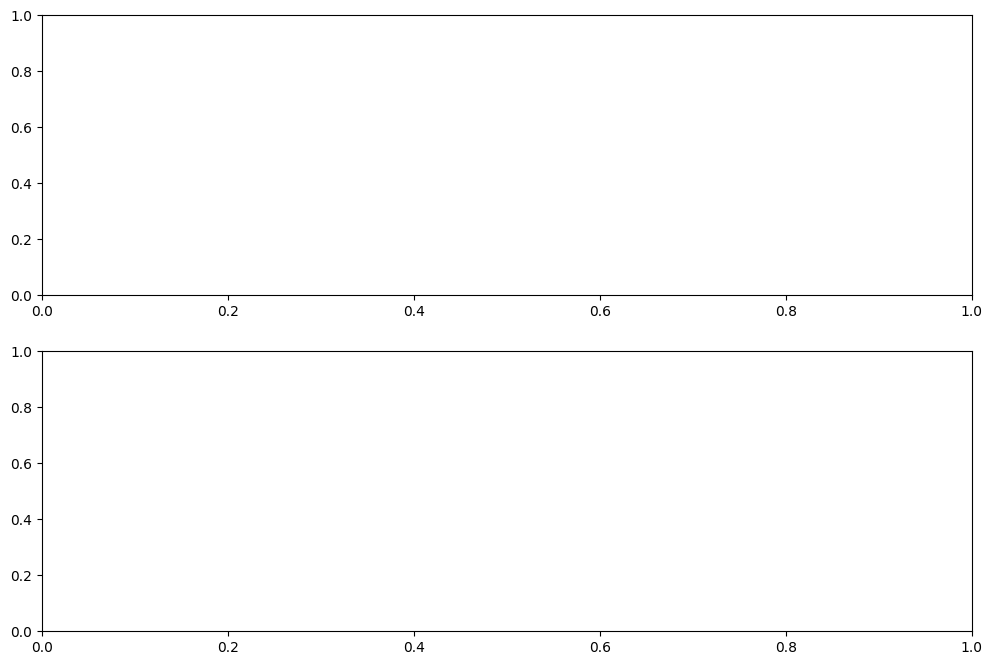

In [18]:
fig, ax1, ax2 = setup_plots()
train_losses = []
train_steps = []
spike_rates_history = []

In [19]:
start_step = 0
if RESUME_FROM:
	checkpoint = torch.load(RESUME_FROM, map_location=device)
	model.load_state_dict(checkpoint['model'])
	optimizer.load_state_dict(checkpoint['optimizer'])
	start_step = checkpoint['step']
	print(f"Resumed from step {start_step}")

In [20]:
step = start_step

model.train()
optimizer.zero_grad()

for epoch in range(NUM_EPOCHS):
	pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
	
	for batch in pbar:
		if MAX_STEPS and step >= MAX_STEPS:
			break
		
		lr = LR #get_lr_schedule(step, WARMUP_STEPS, MAX_STEPS, LR, MIN_LR)
		for param_group in optimizer.param_groups:
			param_group['lr'] = lr
		
		input_ids = batch['input_ids'].to(device)
		labels = batch['labels'].to(device)
		
		with torch.amp.autocast('cuda'):
			logits, _ = model(input_ids)
			loss = F.cross_entropy(logits.view(-1, logits.size(-1)), labels.view(-1))
			loss = loss / GRADIENT_STEPS
		
		loss.backward()

		if (step + 1) % GRADIENT_STEPS == 0:
			torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
			optimizer.step()
			optimizer.zero_grad()

			if step % 10 == 0:
				model.reset_mem()
		
		spike_activity = collect_spike_activity(model)
		current_loss = loss.item() * GRADIENT_STEPS

		train_losses.append(current_loss)
		train_steps.append(step)
		spike_rates_history.append(spike_activity.get("spike_rate/overall", 0))
		
		pbar.set_postfix({'loss': f'{current_loss:.4f}', 'lr': f'{lr:.2e}', 'step': step})
		pbar.update(1)

		if step % 50 == 0:
			update_plots(ax1, ax2, train_steps, train_losses, spike_rates_history, OUTPUT_DIR)
		
		if step % EVAL_INTERVAL == 0 and step > 0:
			eval_loss = evaluate(model, eval_loader, device)
			perplexity = math.exp(eval_loss)
			
			pbar.write(f"Step {step}: eval_loss={eval_loss:.4f}, perplexity={perplexity:.2f}")
			model.train()
		
		if step % SAVE_INTERVAL == 0 and step > 0:
			checkpoint = {
				'model': model.state_dict(),
				'optimizer': optimizer.state_dict(),
				'step': step,
				'epoch': epoch,
				'config': config
			}
			
			checkpoint_path = os.path.join(OUTPUT_DIR, f"checkpoint_step_{step}.pt")
			torch.save(checkpoint, checkpoint_path)
			pbar.write(f"Saved checkpoint to {checkpoint_path}")
		
		step += 1
		
pbar.close()
final_checkpoint = {
	'model': model.state_dict(),
	'optimizer': optimizer.state_dict(),
	'step': step,
	'epoch': epoch,
	'config': config,
}

final_path = os.path.join(OUTPUT_DIR, f"final_model.pt")
torch.save(final_checkpoint, final_path)
print(f"Training completed. Final model saved to {final_path}")

Epoch 1/1: 1046it [26:43,  1.53s/it, loss=10.9964, lr=1.00e-04, step=1000]C:\Users\Cihan\AppData\Local\Temp\ipykernel_32\129283327.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 10773it [1:50:20,  1.63it/s]
Epoch 1/1: 1000it [2:17:04,  8.22s/it, loss=10.9964, lr=1.00e-04, step=1000]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [20]:
# Initialize training state
epoch = 0
step = 0
best_val_loss = float('inf')
start_time = time.time()

# Resume from checkpoint if specified
if RESUME_FROM and os.path.exists(RESUME_FROM):
    print(f"Resuming from {RESUME_FROM}")
    checkpoint = torch.load(RESUME_FROM, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint.get('epoch', 0)
    step = checkpoint.get('step', 0)
    best_val_loss = checkpoint.get('best_val_loss', float('inf'))
    print(f"Resumed from epoch {epoch}, step {step}")

In [ ]:
# Training loop
for current_epoch in range(epoch, NUM_EPOCHS):
    print(f"\n=== Epoch {current_epoch + 1}/{NUM_EPOCHS} ===")
    
    # Update learning rate for this epoch
    current_lr = get_lr_schedule(step, WARMUP_STEPS, MAX_STEPS, LR, LR * 0.1)
    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr
    
    print(f"Learning rate: {current_lr:.2e}")
    
    # Training epoch
    print("Training...")
    train_loss = train_epoch(
        model=model,
        dataloader=train_loader, 
        optimizer=optimizer,
        device=device,
        gradient_accumulation_steps=GRADIENT_STEPS,
        max_grad_norm=MAX_GRAD_NORM
    )
    
    # Collect spike activity after training
    spike_activity = collect_spike_activity(model)
    overall_spike_rate = spike_activity.get("spike_rate/overall", 0.0)
    
    # Update metrics
    train_losses.append(train_loss)
    train_steps.append(current_epoch)
    spike_rates_history.append(overall_spike_rate)
    
    print(f"Epoch {current_epoch + 1} - Train Loss: {train_loss:.4f}")
    print(f"Spike Rate: {overall_spike_rate:.4f}")
    
    # Evaluation
    if (current_epoch + 1) % (EVAL_INTERVAL // len(train_loader)) == 0 or current_epoch == NUM_EPOCHS - 1:
        print("Evaluating...")
        val_loss = evaluate(model, eval_loader, device)
        print(f"Validation Loss: {val_loss:.4f}")
        
        # Update plots
        update_plots(ax1, ax2, train_steps, train_losses, spike_rates_history, OUTPUT_DIR)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_checkpoint = {
                'epoch': current_epoch,
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_val_loss': best_val_loss,
                'config': config,
                'model_size': MODEL_SIZE,
                'spike_rates': spike_activity
            }
            torch.save(best_checkpoint, os.path.join(OUTPUT_DIR, f'best_model_{MODEL_SIZE}.pt'))
            print(f"✓ New best model saved (val_loss: {val_loss:.4f})")
        
        # Log all spike rates
        if spike_activity:
            print("Spike rates by layer:")
            for layer_name, rate in spike_activity.items():
                if 'spike_rate' in layer_name:
                    print(f"  {layer_name}: {rate:.4f}")
    
    # Regular checkpointing
    if (current_epoch + 1) % (SAVE_INTERVAL // len(train_loader)) == 0:
        checkpoint = {
            'epoch': current_epoch,
            'step': step,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': best_val_loss,
            'best_val_loss': best_val_loss,
            'config': config,
            'model_size': MODEL_SIZE,
            'spike_rates': spike_activity
        }
        torch.save(checkpoint, os.path.join(OUTPUT_DIR, f'checkpoint_epoch_{current_epoch + 1}.pt'))
        print(f"✓ Checkpoint saved at epoch {current_epoch + 1}")
    
    # Update step counter (approximate)
    step += len(train_loader) // GRADIENT_STEPS
    
    # Early stopping conditions
    if train_loss > 15.0:
        print(f"⚠️  WARNING: Training loss explosion ({train_loss:.4f}). Consider reducing learning rate.")
    
    if train_loss < 0.1:
        print(f"✓ Training loss very low ({train_loss:.4f}). Model may be converging.")
    
    # Memory cleanup
    torch.cuda.empty_cache()


=== Epoch 1/1 ===
Learning rate: 0.00e+00
Training...


Training: 0it [00:00, ?it/s]C:\Users\Cihan\AppData\Local\Temp\ipykernel_24632\1224566086.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 3083it [1:17:23,  1.45s/it]

In [ ]:
# Final results
total_time = time.time() - start_time
print(f"\n=== Training Complete ===")
print(f"Total time: {total_time/3600:.2f} hours")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final spike rate: {spike_rates_history[-1]:.4f}")

# Save final model
final_checkpoint = {
    'epoch': NUM_EPOCHS,
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses[-1] if train_losses else float('inf'),
    'val_loss': best_val_loss,
    'best_val_loss': best_val_loss,
    'config': config,
    'model_size': MODEL_SIZE,
    'training_time': total_time,
    'final_spike_rates': spike_activity
}
torch.save(final_checkpoint, os.path.join(OUTPUT_DIR, f'final_model_{MODEL_SIZE}.pt'))
print(f"✓ Final model saved")

# Final plot update
update_plots(ax1, ax2, train_steps, train_losses, spike_rates_history, OUTPUT_DIR)
plt.show()